In [1]:
import mne
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import os
import re

# Multiprocessing
import deepgraph as dg
from multiprocessing import Pool

import torch


In [2]:
%matplotlib inline
cmap = sns.cm.rocket_r

# Data Preparation

In [3]:
# Common functions
def get_eeg_file(unique_id): 
  rootdir = "./Data"
  sub,  taks = unique_id.split('_')
  regex = re.compile('(.*{}.*{}.*edf$)'.format(sub, taks))

  for root, dirs, files in os.walk(rootdir):
    for file in files:
      if regex.match(file):
        return file
      
def split_given_size(a, size):
    new_array =  np.array_split(a, np.arange(size,a.shape[1],size), axis=1)
    if(new_array[-1].shape[1] < new_array[0].shape[1]):
        new_array = new_array[:-1]
    return new_array

def get_raw_eeg(filename, root_dir = "./Data/"):
    raw = mne.io.read_raw_edf(root_dir + filename)
    return raw
#split_given_size(np.arange(1000),7)

In [4]:
def graph_corr_matrix(corr, channels):
    sns.heatmap(np.average(corr, axis=0), cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

In [5]:
df = pd.read_excel("Demographic_List.xlsx")

df.shape

(383, 9)

In [6]:
df.groupby("Condition").count()

,sub,Age,Gender,Study,count,session,task,Headset
Condition,,,,,,,,
AD,52,52,52,52,52,52,52,52
HC,224,224,224,224,224,224,224,224
MCI,107,107,107,107,107,107,107,107


In [7]:
conditions = set(df["Condition"])
conditions

{'AD', 'HC', 'MCI'}

In [8]:
# Preprocessing
df["unique_id"] = df["sub"].astype(str) + "_" + df["task"]
df["filename"] = df["unique_id"].apply(get_eeg_file)
df = df[df["Condition"] != "MCI"]

#df.to_csv("dataframe.csv")
df.head()

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id,filename
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24,9003_RSEC,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24,9003_RSEO,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24,9004_RSEC,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24,9004_RSEO,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24,9006_RSEC,INSPEC.INIT.900601000.130217.115256.Signals.Ra...


In [9]:
df.shape

(276, 11)

In [10]:
# Read EEG raw files and save them in a dict for later use 
raw_files = {} 
eeg_min_size = 308224
for _, s in df.iterrows(): 
    raw_files[s["unique_id"]] = get_raw_eeg(s["filename"])
    shape = raw_files[s["unique_id"]].get_data().shape[1] 
    eeg_min_size = shape if shape < eeg_min_size else eeg_min_size

eeg_min_size

Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\Data\INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEC_01.edited.18.134.318.132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\Data\INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEO_01.edited.47.187.347.192.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\Data\INSPEC.INIT.900401000.070217.105622.Signals.Raw_RSEC_01.edited.25.108.325.112.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\Data\INSPEC.INIT.900401000.070217.105622.Signals.Raw_RSEO_01.edited.347.72.647.76.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documen

285696

In [11]:
eeg_max_size = 1024
n_features = 20
n_samples = len(raw_files) 
channels = raw_files["9003_RSEC"].ch_names[:20]


_raw_files = raw_files


In [16]:
for key, value in raw_files.items(): 
    print(key)
    value.pick_channels(channels)
    #value.resample(512.)
    value.resample(256.)
    value.filter(l_freq=1., h_freq=100.)

    #asr = mne.preprocessing.ASR(sfreq=sample.info["sfreq"], cutoff=5, blocksize=value._data.shape[1])
    #asr.fit(value._data)
    #value._data = asr.transform(value._data)
    #break

9003_RSEC
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

9003_RSEO
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.5

In [33]:
raw_files["9003_RSEC"]

<RawEDF | INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEC_01.edited.18.134.318.132.edf, 20 x 76800 (300.0 s), ~11.7 MB, data loaded>

In [32]:
raw_files["9003_RSEC"]._data.shape

(20, 76800)

In [ ]:
path = "Data/ASR/"

for key, value in raw_files.items(): 
    value.save(path + key + ".fif")


In [21]:
new_df = []
X = np.zeros((n_samples, n_features, eeg_max_size))
X.shape
# Fill matrix X with data 
for i, s in df.iterrows(): 
    raw = raw_files[s["unique_id"]]
    shape = raw.get_data().shape[1]
    data = raw.get_data(channels) 
    #data = np.pad(data, [(0,0),(0, eeg_max_size-shape )], 'wrap')
    #print(data.shape)
    data = split_given_size(data, 2560) #WINDOW SIZE 
    #print(len(data))
    for i, d in enumerate(data): 
        raw = torch.Tensor(d)
        corr = torch.corrcoef(raw)
        object = {
            "UID" : s["unique_id"] + "_{}".format(i), 
            "Condition" : s["Condition"],
            "Correlation" : corr.numpy()
        }
        new_df.append(object)

In [22]:
new_df = pd.DataFrame(new_df)
new_df

,UID,Condition,Correlation
0,9003_RSEC_0,HC,"[[1.0, 0.96479917, 0.96608853, 0.6390984, 0.42..."
1,9003_RSEC_1,HC,"[[1.0, 0.9073824, 0.8497228, 0.7064789, 0.6276..."
2,9003_RSEC_2,HC,"[[1.0, 0.9340229, 0.8753614, 0.74093723, 0.575..."
3,9003_RSEC_3,HC,"[[1.0, 0.88382626, 0.7778786, 0.60819596, 0.51..."
4,9003_RSEC_4,HC,"[[1.0, 0.91318536, 0.8608893, 0.70672196, 0.58..."
...,...,...,...
8272,9632_RSEO_25,HC,"[[1.0, 0.75894046, 0.51762056, -0.083940454, 0..."
8273,9632_RSEO_26,HC,"[[0.99999994, 0.7505352, 0.54481626, -0.073295..."
8274,9632_RSEO_27,HC,"[[1.0, 0.7721308, 0.57405615, 0.012106675, 0.1..."
8275,9632_RSEO_28,HC,"[[0.99999994, 0.7182817, 0.50049216, -0.080228..."


In [23]:
new_df.groupby("Condition").count()

,UID,Correlation
Condition,,
AD,1560,1560
HC,6717,6717


In [24]:
new_df.to_pickle("Results/corr_dataset_10_seconds_filter_256.pkl")

In [ ]:
pd.read_pickle("corr_dataset.pkl")

In [25]:
hc_idx = list(np.where(new_df["Condition"] == "HC")[0])
ad_idx = list(np.where(new_df["Condition"] == "AD")[0])
corr_hc = np.zeros((20,20))
corr_ad = np.zeros((20,20))

In [26]:
for i in hc_idx: 
    #print(new_df.loc[i]["Correlation"].shape)
    corr_hc += new_df.loc[i]["Correlation"]
corr_hc = corr_hc/len(hc_idx)
for i in ad_idx: 
    corr_ad += new_df.loc[i]["Correlation"]

corr_ad = corr_ad/len(ad_idx)

<AxesSubplot:>

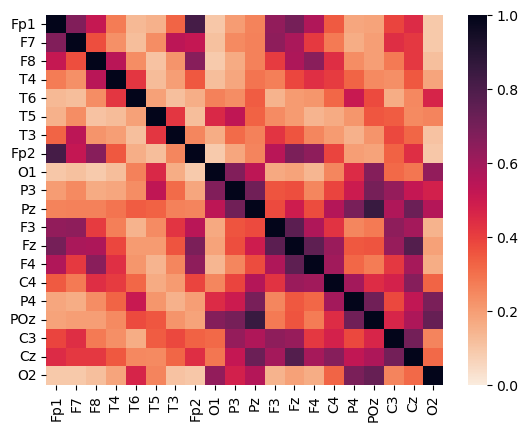

In [27]:


sns.heatmap(corr_hc**2, cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

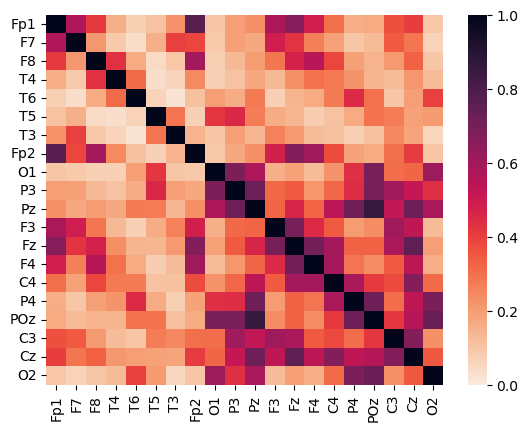

In [28]:
sns.heatmap(corr_ad**2, cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

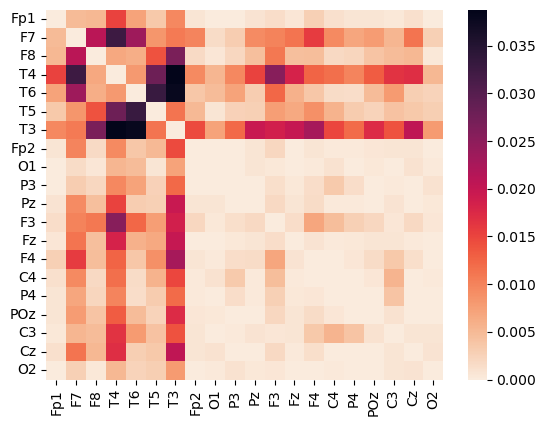

In [31]:
sns.heatmap((corr_hc-corr_ad)**2, cmap=cmap, xticklabels=channels, yticklabels=channels)

In [34]:
np.save('samples_corr', X_corr)
np.save('p_values', p_corr)

# Paper Dataset